In [61]:
import pandas as pd
import sqlite3

conn = sqlite3.connect("german_credit.db")

In [62]:
query = "SELECT * FROM credit LIMIT 5;"
head = pd.read_sql_query(query, conn)
head

,Status_of_existing_checking_account,Duration_in_month,Credit_history,Purpose,Credit_amount,Savings_account_bonds,Present_employment_since,Installment_rate,Personal_status_and_sex,Other_debtors,...,Property,Age,Other_installment_plans,Housing,Number_of_existing_credits,Job,People_liable,Telephone,Foreign_worker,Target
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,0
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,0


In [63]:
cursor = conn.cursor()
cursor.execute("PRAGMA table_info(credit);")
for col in cursor.fetchall():
    print(col)

(0, 'Status_of_existing_checking_account', 'TEXT', 0, None, 0)
(1, 'Duration_in_month', 'INTEGER', 0, None, 0)
(2, 'Credit_history', 'TEXT', 0, None, 0)
(3, 'Purpose', 'TEXT', 0, None, 0)
(4, 'Credit_amount', 'INTEGER', 0, None, 0)
(5, 'Savings_account_bonds', 'TEXT', 0, None, 0)
(6, 'Present_employment_since', 'TEXT', 0, None, 0)
(7, 'Installment_rate', 'INTEGER', 0, None, 0)
(8, 'Personal_status_and_sex', 'TEXT', 0, None, 0)
(9, 'Other_debtors', 'TEXT', 0, None, 0)
(10, 'Present_residence_since', 'INTEGER', 0, None, 0)
(11, 'Property', 'TEXT', 0, None, 0)
(12, 'Age', 'INTEGER', 0, None, 0)
(13, 'Other_installment_plans', 'TEXT', 0, None, 0)
(14, 'Housing', 'TEXT', 0, None, 0)
(15, 'Number_of_existing_credits', 'INTEGER', 0, None, 0)
(16, 'Job', 'TEXT', 0, None, 0)
(17, 'People_liable', 'INTEGER', 0, None, 0)
(18, 'Telephone', 'TEXT', 0, None, 0)
(19, 'Foreign_worker', 'TEXT', 0, None, 0)
(20, 'Target', 'INTEGER', 0, None, 0)


---
### DATA EXTRACTION VIA SQL QUERIES

In [71]:
num_clients = pd.read_sql_query("SELECT COUNT(*) FROM credit;", conn).iloc[0, 0]
target_count = pd.read_sql_query("SELECT Target, COUNT(*) as total "
                             "FROM credit "
                             "GROUP BY Target;", conn)

query = """
SELECT Target, AVG(Credit_amount) AS mean_credit
FROM credit
GROUP BY Target;
"""
average_credit_amount = pd.read_sql_query(query, conn)


query = """
SELECT Purpose, Target, COUNT(*) as total
FROM credit
GROUP BY Purpose, Target
"""
purpose_per_target = pd.read_sql_query(query, conn)

query = """
SELECT Purpose, Target, COUNT(*) AS total
FROM credit
GROUP BY Purpose, Target
HAVING total = (
    SELECT MAX(cnt)
    FROM (
        SELECT COUNT(*) AS cnt
        FROM credit AS c2
        WHERE c2.Target = credit.Target
        GROUP BY Purpose
    )
)
"""
most_frequent_purpose = pd.read_sql_query(query, conn)

query = """
SELECT Housing, Target, COUNT(*) as total
FROM Credit
GROUP BY Housing, Target
"""
housing_per_target = pd.read_sql_query(query, conn)

query = """
SELECT
  CASE
    WHEN Age < 25 THEN '18-24'
    WHEN Age < 35 THEN '25-34'
    WHEN Age < 50 THEN '35-49'
    ELSE '50+'
  END AS age_group,
  COUNT(*) AS total
FROM credit
GROUP BY age_group
ORDER BY age_group;
"""
age_distribution = pd.read_sql_query(query, conn)

query = """
SELECT Personal_status_and_sex, Target, COUNT(*) as total
FROM credit
GROUP BY Personal_status_and_sex
ORDER BY total DESC
"""
personal_status_distribution = pd.read_sql_query(query, conn)

query = """
SELECT Credit_history, Target, COUNT(*) as total
FROM credit
GROUP BY Credit_history
ORDER BY total DESC
"""
credit_history_distribution = pd.read_sql_query(query, conn)

query = """
SELECT Other_debtors, AVG(Target) AS good_credit_rate
FROM credit
GROUP BY Other_debtors;
"""
other_debtors_good_credit_rate = pd.read_sql_query(query, conn)

query = """
SELECT Duration_in_month, AVG(Target) AS good_credit_rate
FROM credit
GROUP BY Duration_in_month
ORDER BY Duration_in_month ASC;
"""
duration_good_credit_rate = pd.read_sql_query(query, conn)

---
### DATA VISUALIZATION

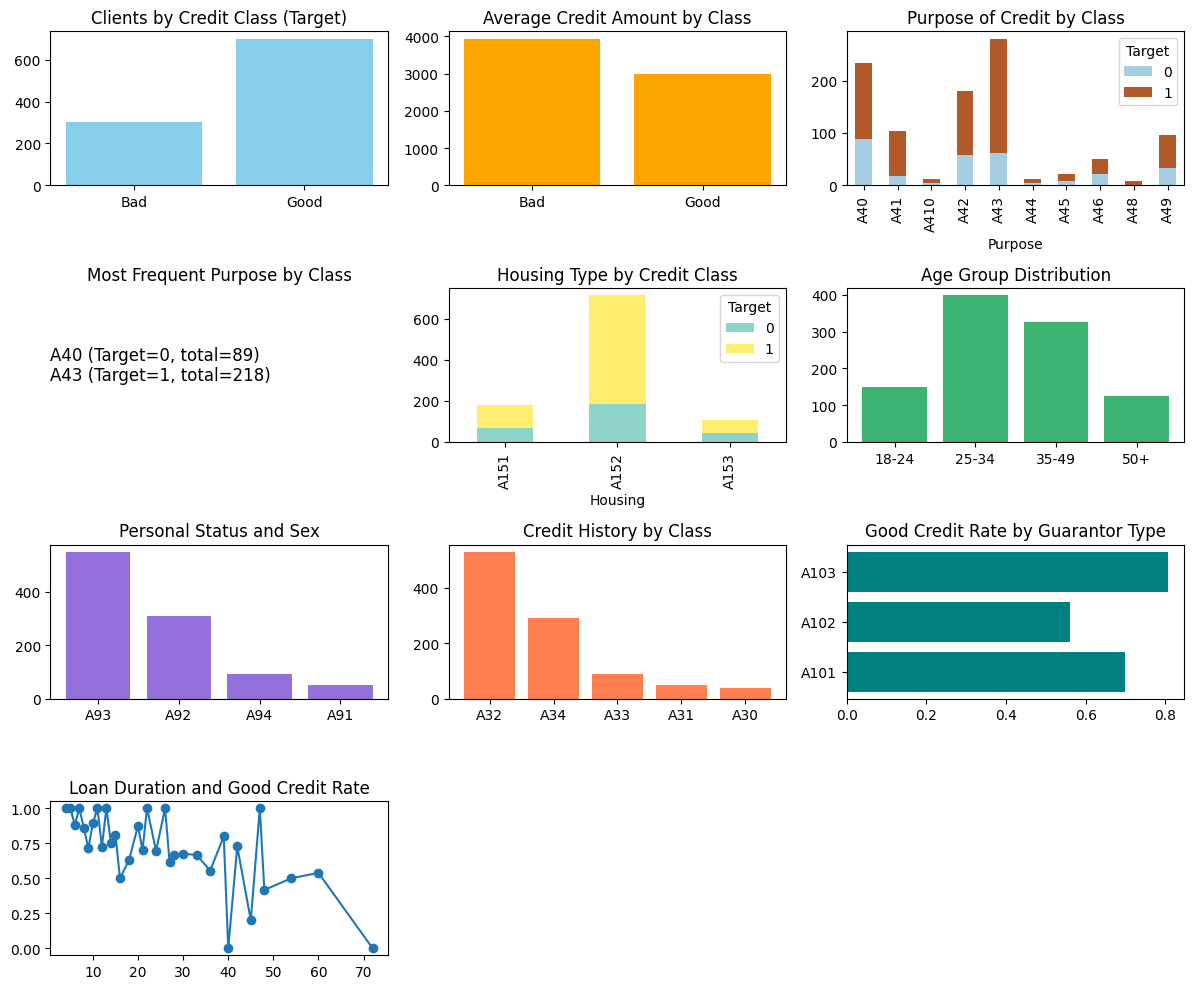

In [74]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(4, 3, figsize=(12, 10))
axs = axs.flatten()

# 1. Clients by Target
axs[0].bar(target_count["Target"], target_count["total"], color="skyblue")
axs[0].set_title("Clients by Credit Class (Target)")
axs[0].set_xticks([0, 1])
axs[0].set_xticklabels(["Bad", "Good"])

# 2. Average credit amount by class
axs[1].bar(average_credit_amount["Target"], average_credit_amount["mean_credit"], color="orange")
axs[1].set_title("Average Credit Amount by Class")
axs[1].set_xticks([0, 1])
axs[1].set_xticklabels(["Bad", "Good"])

# 3. Purpose by Target (stacked)
purpose_pivot = purpose_per_target.pivot(index="Purpose", columns="Target", values="total").fillna(0)
purpose_pivot.plot(kind="bar", stacked=True, ax=axs[2], colormap="Paired")
axs[2].set_title("Purpose of Credit by Class")

# 4. Most frequent purpose (as text)
text = "\n".join(f"{row.Purpose} (Target={row.Target}, total={row.total})"
                 for _, row in most_frequent_purpose.iterrows())
axs[3].axis("off")
axs[3].set_title("Most Frequent Purpose by Class")
axs[3].text(0, 0.5, text, fontsize=12, verticalalignment='center')

# 5. Housing by class
housing_pivot = housing_per_target.pivot(index="Housing", columns="Target", values="total").fillna(0)
housing_pivot.plot(kind="bar", stacked=True, ax=axs[4], colormap="Set3")
axs[4].set_title("Housing Type by Credit Class")

# 6. Age group distribution
axs[5].bar(age_distribution["age_group"], age_distribution["total"], color="mediumseagreen")
axs[5].set_title("Age Group Distribution")

# 7. Personal status and sex
axs[6].bar(personal_status_distribution["Personal_status_and_sex"],
           personal_status_distribution["total"], color="mediumpurple")
axs[6].set_title("Personal Status and Sex")

# 8. Credit history
axs[7].bar(credit_history_distribution["Credit_history"],
           credit_history_distribution["total"], color="coral")
axs[7].set_title("Credit History by Class")

# 9. Guarantors and good credit rate
axs[8].barh(other_debtors_good_credit_rate["Other_debtors"],
            other_debtors_good_credit_rate["good_credit_rate"], color="teal")
axs[8].set_title("Good Credit Rate by Guarantor Type")

# 10. Loan duration vs good credit rate
axs[9].plot(duration_good_credit_rate["Duration_in_month"],
            duration_good_credit_rate["good_credit_rate"], marker="o")
axs[9].set_title("Loan Duration and Good Credit Rate")

# Hide the two empty subplots
axs[10].axis("off")
axs[11].axis("off")

plt.tight_layout()
plt.show()

---
## TARGET PREDICTION VIA XGBOOST

In [95]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold
import xgboost as xgb
import numpy as np

extract_query = """
SELECT * FROM credit;
"""
data = pd.read_sql_query(extract_query, conn)
x = data.drop(columns=["Target"])
for col in x.select_dtypes(include="object").columns:
    x[col] = x[col].astype("category")
y = data["Target"]

In [96]:
model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    enable_categorical=True,
    random_state=42
)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
acc_scores, recall_scores, f1_scores, auc_scores = [], [], [], []
for fold, (train_idx, test_idx) in enumerate(skf.split(x, y), 1):
    x_train, x_test = x.iloc[train_idx], x.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    y_proba = model.predict_proba(x_test)[:, 1]

    acc_scores.append(accuracy_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    auc_scores.append(roc_auc_score(y_test, y_proba))

    print(f"Fold {fold}:")
    print(f"  Accuracy: {acc_scores[-1]:.4f}")
    print(f"  Recall:   {recall_scores[-1]:.4f}")
    print(f"  F1 Score: {f1_scores[-1]:.4f}")
    print(f"  AUC:      {auc_scores[-1]:.4f}")
    print("----------------------------")

print("Average metrics across folds:")
print(f"Accuracy: {np.mean(acc_scores):.4f}")
print(f"Recall:   {np.mean(recall_scores):.4f}")
print(f"F1 Score: {np.mean(f1_scores):.4f}")
print(f"AUC:      {np.mean(auc_scores):.4f}")

Fold 1:
  Accuracy: 0.7300
  Recall:   0.8429
  F1 Score: 0.8138
  AUC:      0.7536
----------------------------
Fold 2:
  Accuracy: 0.7650
  Recall:   0.8571
  F1 Score: 0.8362
  AUC:      0.7488
----------------------------
Fold 3:
  Accuracy: 0.7450
  Recall:   0.8571
  F1 Score: 0.8247
  AUC:      0.7560
----------------------------
Fold 4:
  Accuracy: 0.7550
  Recall:   0.8786
  F1 Score: 0.8339
  AUC:      0.7819
----------------------------
Fold 5:
  Accuracy: 0.7750
  Recall:   0.8857
  F1 Score: 0.8464
  AUC:      0.7750
----------------------------
Average metrics across folds:
Accuracy: 0.7540
Recall:   0.8643
F1 Score: 0.8310
AUC:      0.7630


Base model: XGBoost with categorical support

|Metric   | Value  |
|---------|--------|
|Accuracy | 0.7540 |
|Recall   | 0.8643 |
|F1 Score | 0.8310 |
|AUC      | 0.7630 |


In [100]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score

base_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    enable_categorical=True,
    random_state=42
)

param_grid = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2],
    "n_estimators": [100, 200],
    "subsample": [0.8, 1],
    "colsample_bytree": [0.8, 1],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring=make_scorer(f1_score),
    cv=cv,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(x, y)

print("Best hyperparameters:", grid_search.best_params_)
print(f"Accuracy: {grid_search.best_score_:.4f}")
print(f"Recall: {recall_score(y, grid_search.predict(x)):.4f}")
print(f"F1 Score: {f1_score(y, grid_search.predict(x)):.4f}")
print(f"AUC: {roc_auc_score(y, grid_search.predict_proba(x)[:, 1]):.4f}")


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1}
Accuracy: 0.8461
Recall: 0.9743
F1 Score: 0.9472
AUC: 0.9744


XGBoost with hyperparameter tuning

|Metric   | Value  |Improvement|
|---------|--------|-----------|
|Accuracy | 0.8461 |+0.0921|
|Recall   | 0.9743 |+0.11|
|F1 Score | 0.9472 |+0.1162|
|AUC      | 0.9744 |+0.2114|

---
### FEATURE ANALYSIS WITH SHAP

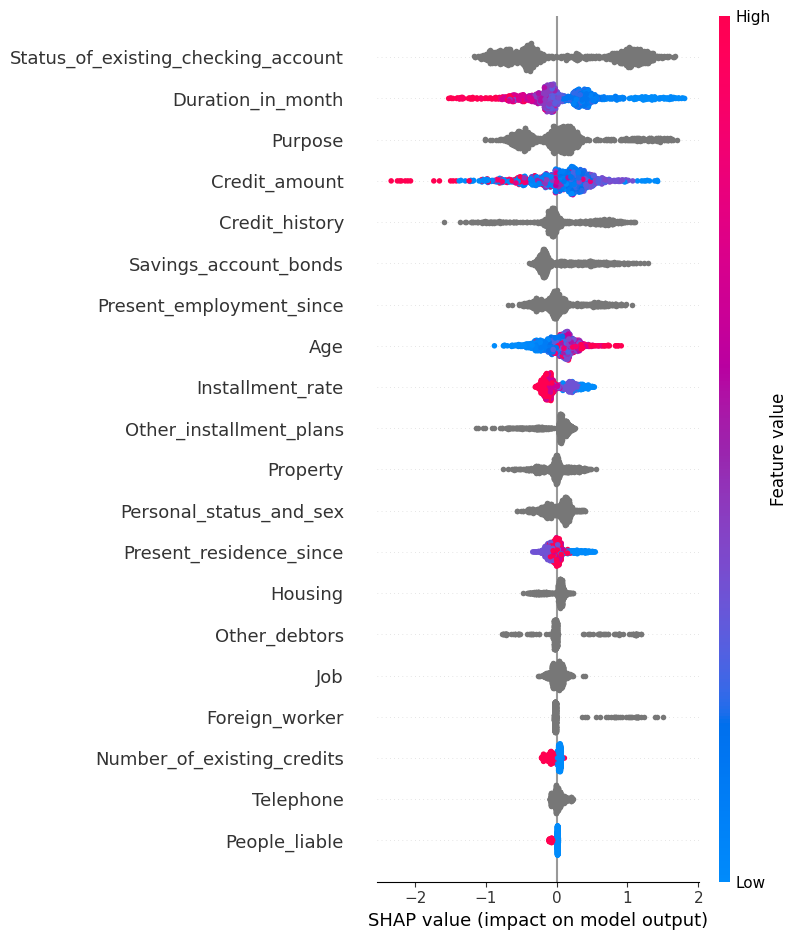

In [111]:
import shap

best_model = grid_search.best_estimator_

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(x)
shap.summary_plot(shap_values, x)